# 05. Prediction Pipelines
Fitting, tuning and packing prediction pipelines

In [1]:
# change wd to repo home
import os
if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
from modules.fm_functions import *

Load data

In [3]:
import pandas as pd
player_data_2022 = pd.read_csv('./data/FM_fbref_combined_data_2022.csv', index_col='_Player_').iloc[:, 1:].dropna(axis=0)
player_data_2023 = pd.read_csv('./data/FM_fbref_combined_data_2023.csv', index_col='_Player_').iloc[:, 1:].dropna(axis=0)

team_pca_2022 = pd.read_csv('./data/2022_team_pca.csv', index_col=0)
team_pca_2023 = pd.read_csv('./data/2023_team_pca.csv', index_col=0)
team_pca_2022.columns = ['team_pca_0', 'team_pca_1']
team_pca_2023.columns = ['team_pca_0', 'team_pca_1']

player_team_2022 = pd.read_csv('./data/2022_FBRef_meandiff.csv', index_col=1).loc[:, ['_Squad_']]
player_team_2023 = pd.read_csv('./data/2023_FBRef_meandiff.csv', index_col=1).loc[:, ['_Squad_']]

In [5]:
combined_data_2022 = pd.merge(player_data_2022.join(player_team_2022).reset_index(), team_pca_2022, left_on='_Squad_', right_on=team_pca_2022.index)
combined_data_2023 = pd.merge(player_data_2023.join(player_team_2023).reset_index(), team_pca_2023, left_on='_Squad_', right_on=team_pca_2023.index)

combined_data_2022.index = combined_data_2022['_Player_']
combined_data_2023.index = combined_data_2023['_Player_']

combined_data_2022.drop(['_Player_', '_Squad_'], axis=1, inplace=True)
combined_data_2023.drop(['_Player_', '_Squad_'], axis=1, inplace=True)


In [7]:
feature_columns = all_stats_columns + ['team_pca_0', 'team_pca_1']

X = combined_data_2022[feature_columns].values
y = combined_data_2022[FM_columns].values

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, combined_data_2022.index, test_size=0.33, random_state=42)

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

<Axes: >

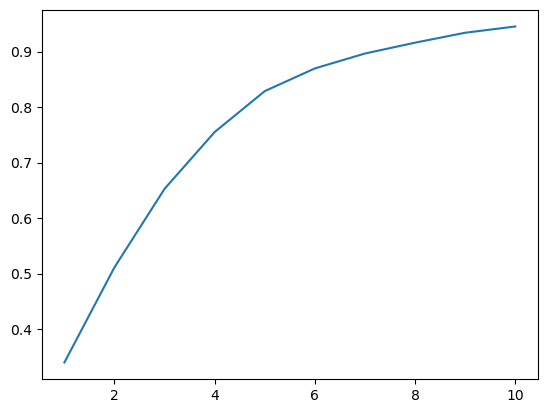

In [18]:
pca_results = {}

for n_components in range(1, 11):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    pca_results[n_components] = pca.explained_variance_ratio_.sum()

sns.lineplot(pca_results)

In [19]:
pipeline = Pipeline([
    ('pca', PCA(n_components=5)),
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

In [20]:
param_grid = {
    # 'mlp__hidden_layer_sizes' : [(50,)],
    # 'mlp__hidden_layer_sizes' : [(50,), (100,)],
    'mlp__hidden_layer_sizes' : [(50,), (100,), (50, 50), (25, 50, 25)],
    # 'mlp__activation' : ['tanh']
    'mlp__activation' : ['tanh', 'relu']
}

In [21]:
grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pca', PCA(n_components=5)),
                                             ('mlp',
                                              MLPRegressor(max_iter=1000,
                                                           random_state=42))]),
                   param_distributions={'mlp__activation': ['tanh', 'relu'],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (50, 50),
                                                                    (25, 50,
                                                                     25)]})

In [12]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'pca__n_components': 10, 'mlp__hidden_layer_sizes': (50,), 'mlp__activation': 'tanh'}
Best cross-validation score:  0.22953922217975112


In [22]:
model = grid_search.best_estimator_
model.fit(X, y)

Pipeline(steps=[('pca', PCA(n_components=5)),
                ('mlp',
                 MLPRegressor(activation='tanh', hidden_layer_sizes=(50,),
                              max_iter=1000, random_state=42))])

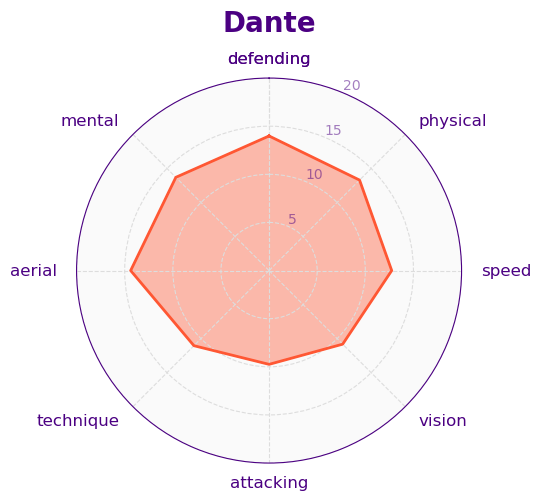

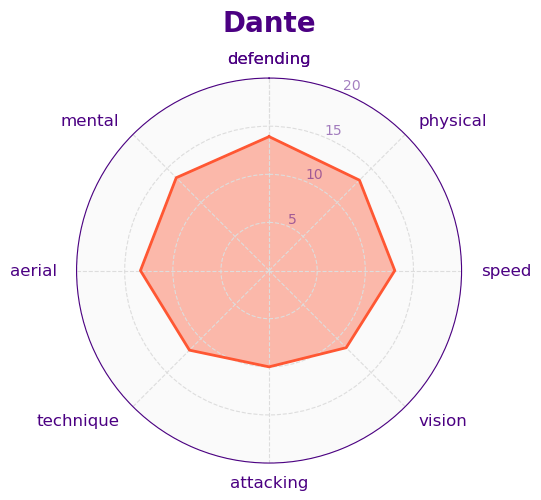

In [27]:
test_name = 'Dante'

predictions_2022 = model.predict(combined_data_2022.loc[[test_name], feature_columns].values)
predictions_2022 = pd.Series(predictions_2022[0], index=FM_columns)
predictions_2022['_Player_'] = test_name
predictions_2022_graph = calculate_skill_nodes(predictions_2022)
plot_fm_radar(predictions_2022_graph, gk=False)

predictions_2023 = model.predict(combined_data_2023.loc[[test_name], feature_columns].values)
predictions_2023 = pd.Series(predictions_2023[0], index=FM_columns)
predictions_2023['_Player_'] = test_name
predictions_2023_graph = calculate_skill_nodes(predictions_2023)
plot_fm_radar(predictions_2023_graph, gk=False)


## MVP: Ordinary Least Squares

In [179]:
from sklearn.linear_model import ElasticNet

# Initialize the model
eln = ElasticNet(random_state=42)

# Fit the model
eln.fit(X_train, y_train)

# Evaluate the model
print(f'R^2 (train): {eln.score(X_train, y_train)}')
print(f'R^2 (test): {eln.score(X_test, y_test)}')

R^2 (train): 0.1578686595387767
R^2 (test): 0.155470962180969


## MVP: Partial Least Squares

In [180]:
from sklearn.cross_decomposition import PLSRegression

# Initialize the model
pls = PLSRegression()

# Fit the model
pls.fit(X_train, y_train)

# Evaluate the model
print(f'R^2 (train): {pls.score(X_train, y_train)}')
print(f'R^2 (test): {pls.score(X_test, y_test)}')

R^2 (train): 0.17341114695763388
R^2 (test): 0.1750454681358237


## MVP: Random Forest

In [181]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rfr = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, random_state=42)

# Fit the model
rfr.fit(X_train, y_train)

# Evaluate the model
print(f'R^2 (train): {rfr.score(X_train, y_train)}')
print(f'R^2 (test): {rfr.score(X_test, y_test)}')

R^2 (train): 0.28985502312235445
R^2 (test): 0.21454294302463767


## MVP: Extra Trees

In [182]:
from sklearn.ensemble import ExtraTreesRegressor

# Initialize the model
etr = ExtraTreesRegressor(n_estimators=100, max_depth=5, min_samples_split=5, random_state=42)

# Fit the model
etr.fit(X_train, y_train)

# Evaluate the model
print(f'R^2 (train): {etr.score(X_train, y_train)}')
print(f'R^2 (test): {etr.score(X_test, y_test)}')

R^2 (train): 0.24656025548562052
R^2 (test): 0.20217155009596524


## MVP: MultiOutputRegressor with AdaBoost

In [183]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor

# Initialize the model
abr = AdaBoostRegressor(n_estimators=10)

# Fit the model
mor = MultiOutputRegressor(estimator=abr).fit(X_train, y_train)

# Evaluate the model
print(f'R^2 (train): {mor.score(X_train, y_train)}')
print(f'R^2 (test): {mor.score(X_test, y_test)}')

R^2 (train): 0.23636219769363193
R^2 (test): 0.17364687859326083


## MVP: RegressorChain with AdaBoost

In [184]:
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import AdaBoostRegressor

# Initialize the model
abr = AdaBoostRegressor(n_estimators=10)

# Fit the model
rch = RegressorChain(base_estimator=abr).fit(X_train, y_train)

# Evaluate the model
print(f'R^2 (train): {rch.score(X_train, y_train)}')
print(f'R^2 (test): {rch.score(X_test, y_test)}')

R^2 (train): 0.1673670053723225
R^2 (test): 0.16569347363867962


## MVP: simple NN

In [185]:
from sklearn.neural_network import MLPRegressor

# Initialize the model
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)

# Fit the model
mlp.fit(X_train, y_train)

# Evaluate the model
print(f'R^2 (train): {mlp.score(X_train, y_train)}')
print(f'R^2 (test): {mlp.score(X_test, y_test)}')

R^2 (train): 0.2452456304825875
R^2 (test): 0.23553720337217804


## Playground

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from modules.fm_functions import *
import warnings

warnings.filterwarnings(action='ignore')

In [15]:
def smith_waterman(s1, s2, match_score=2, gap_cost=1):
    """
    Compute the Smith-Waterman score between two strings.
    
    :param s1: First string.
    :param s2: Second string.
    :param match_score: Score for character match.
    :param gap_cost: Cost for gap (insertion/deletion).
    :return: The Smith-Waterman score for the best local alignment.
    """
    m, n = len(s1), len(s2)
    score_matrix = [[0] * (n + 1) for _ in range(m + 1)]
    max_score = 0

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score_matrix[i - 1][j - 1] + (match_score if s1[i - 1] == s2[j - 1] else -match_score)
            delete = score_matrix[i - 1][j] - gap_cost
            insert = score_matrix[i][j - 1] - gap_cost
            score_matrix[i][j] = max(0, match, delete, insert)
            max_score = max(max_score, score_matrix[i][j])

    return max_score

def find_most_similar_strings(target, strings, n=5):
    """
    Find the n most similar strings to the target string from a list of strings using Smith-Waterman score.
    
    :param target: The target string to compare against.
    :param strings: A list of strings to search within.
    :param n: The number of most similar strings to return. Default is 5.
    :return: A list of the n most similar strings.
    """
    # Compute the Smith-Waterman score for each string in the list
    scores = [(string, smith_waterman(target, string)) for string in strings]
    
    # Find the n strings with the highest scores
    most_similar = sorted(scores, key=lambda x: x[1], reverse=True)[:n]
    
    # Extract and return only the strings (not the scores)
    return [string for string, score in most_similar]

In [251]:
playground_X_2022 = pca.transform(combined_data_2022[all_stats_columns])
playground_X_2022 = pd.DataFrame(playground_X_2022, index=combined_data_2022.index)
playground_y = combined_data_2022[predict_columns]

playground_X_2023 = pca.transform(combined_data_2023[all_stats_columns])
playground_X_2023 = pd.DataFrame(playground_X_2023, index=combined_data_2023.index)

In [252]:
find_most_similar_strings('de jong', playground_X_2023.index, n=10)

['Frenkie de Jong',
 'Marten de Roon',
 'Faride Alidou',
 'Jeremie Frimpong',
 'Matthijs de Ligt',
 'Jeong Woo-yeong',
 'Jayden Bogle',
 'Jayden Bogle',
 'Tahith Chong',
 'Sean Longstaff']

In [65]:
test_indices[100:150]

Index(['David Alaba', 'Harvey Elliott', 'Raúl Guti', 'Cenk Özkacar',
       'Aitor Paredes', 'Edoardo Bove', 'Jonathan Tah', 'Sven Botman',
       'Wilfred Ndidi', 'Lucas Torró', 'Arnau Martinez', 'Alexsandro Ribeiro',
       'Matteo Ruggeri', 'Dimitri Payet', 'Pape Gueye', 'Giuseppe Pezzella',
       'Giorgos Kyriakopoulos', 'Éderson', 'Tonny Vilhena', 'M'Bala Nzola',
       'Marquinhos', 'Leroy Sané', 'Anthony Gordon', 'Pablo Barrios',
       'Alessandro Buongiorno', 'Renato Veiga', 'Edimilson Fernandes',
       'Lucas Tousart', 'Achraf Dari', 'Gabriel Strefezza',
       'Stephan El Shaarawy', 'Roberto Gagliardini', 'Nampalys Mendy',
       'Karim Rekik', 'Charles De Ketelaere', 'André Gomes',
       'Florian Niederlechner', 'Cristiano Ronaldo', 'Mads Roerslev',
       'Jérémy Le Douaron', 'Julian Baumgartlinger', 'Noah Fadiga',
       'Ondrej Duda', 'Nordi Mukiele', 'Iván Martín', 'Theo Hernández',
       'Antonio Candreva', 'Kiernan Dewsbury-Hall', 'Willy Boly',
       'Timothy Wea

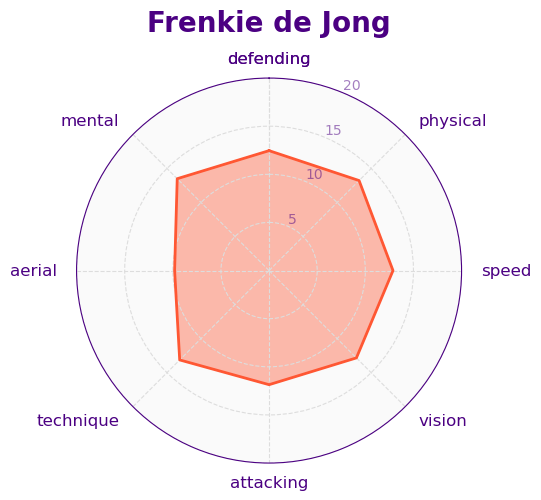

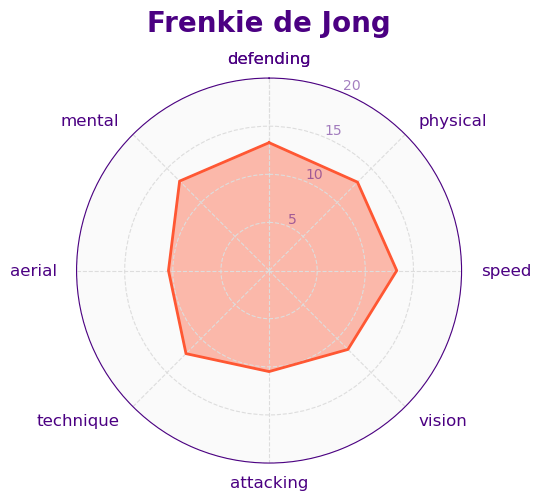

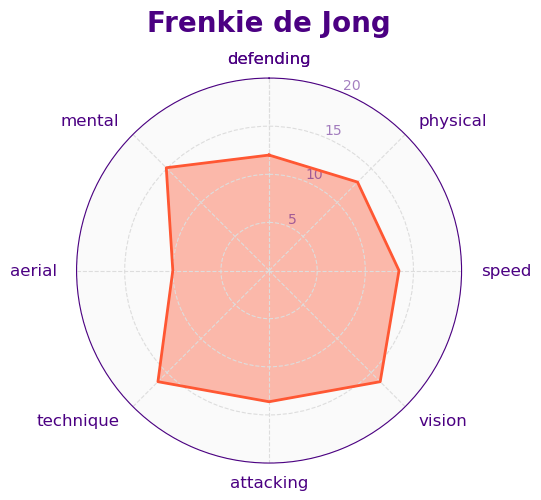

In [253]:
test_name = 'Frenkie de Jong'

model = mlp

predictions_2022 = model.predict(playground_X_2022.loc[[test_name]].values)
predictions_2022 = pd.Series(predictions_2022[0], index=FM_columns)
predictions_2022['_Player_'] = test_name
predictions_2022_graph = calculate_skill_nodes(predictions_2022)
plot_fm_radar(predictions_2022_graph, gk=False)

predictions_2023 = model.predict(playground_X_2023.loc[[test_name]].values)
predictions_2023 = pd.Series(predictions_2023[0], index=FM_columns)
predictions_2023['_Player_'] = test_name
predictions_2023_graph = calculate_skill_nodes(predictions_2023)
plot_fm_radar(predictions_2023_graph, gk=False)

real = playground_y.loc[[test_name]].values
real = pd.Series(real[0], index=FM_columns)
real['_Player_'] = test_name
real_graph = calculate_skill_nodes(real)
plot_fm_radar(real_graph, gk=False)

In [254]:
skills_df = pd.DataFrame({'prediction_2022':predictions_2022,
                          'prediction_2023':predictions_2023,
                          'real':real},
                          index=predict_columns)
skills_df

,prediction_2022,prediction_2023,real
Corners,9.978338,8.504022,9
Crossing,11.598533,11.216992,11
Dribbling,12.428404,11.489871,16
Finishing,9.414415,7.528073,10
First Touch,13.390186,12.519795,17
Free Kick Taking,9.444978,8.114172,13
Heading,9.535685,10.143057,10
Long Shots,11.193511,9.229312,8
Long Throws,8.311041,9.714449,6
Marking,11.255522,12.54734,10


In [255]:
skills_df.corr()

,prediction_2022,prediction_2023,real
prediction_2022,1.000000,0.891510,0.639469
prediction_2023,0.891510,1.000000,0.473449
real,0.639469,0.473449,1.000000


In [256]:
skills_df.mean()

prediction_2022    12.306642
prediction_2023    11.855993
real                    13.0
dtype: object

In [258]:
stats_df = pd.DataFrame({'stats_2022':playground_X_2022.loc[test_name],
                         'stats_2023':playground_X_2023.loc[test_name]})
stats_df

,stats_2022,stats_2023
0,1.402929,-1.320413
1,3.193475,1.451704
2,-0.047241,0.478209
3,2.315885,0.413551
4,0.477216,-1.109277


In [259]:
stats_df.corr()

,stats_2022,stats_2023
stats_2022,1.000000,0.536245
stats_2023,0.536245,1.000000


<Axes: xlabel='stats_2022', ylabel='stats_2023'>

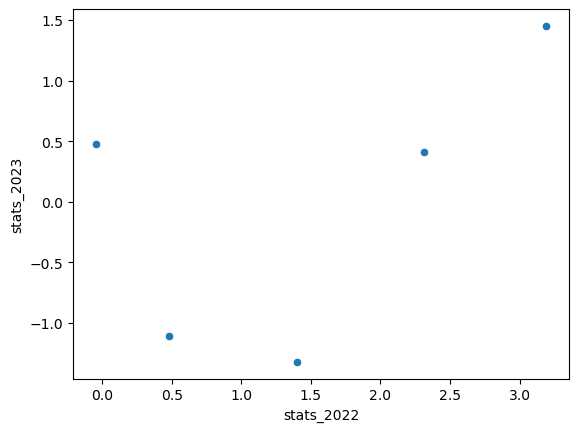

In [260]:
sns.scatterplot(data=stats_df, x='stats_2022', y='stats_2023')

In [261]:
all_predictions = pd.DataFrame(model.predict(playground_X_2022.values),
                               index=playground_X_2022.index,
                               columns=FM_columns)

In [262]:
df1 = all_predictions
df2 = combined_data_2022[FM_columns]

correlations = pd.Series(index=df1.columns)

for col in df1.columns:
    correlations.loc[col] = np.corrcoef(df1[col], df2[col])[0, 1]

<Axes: >

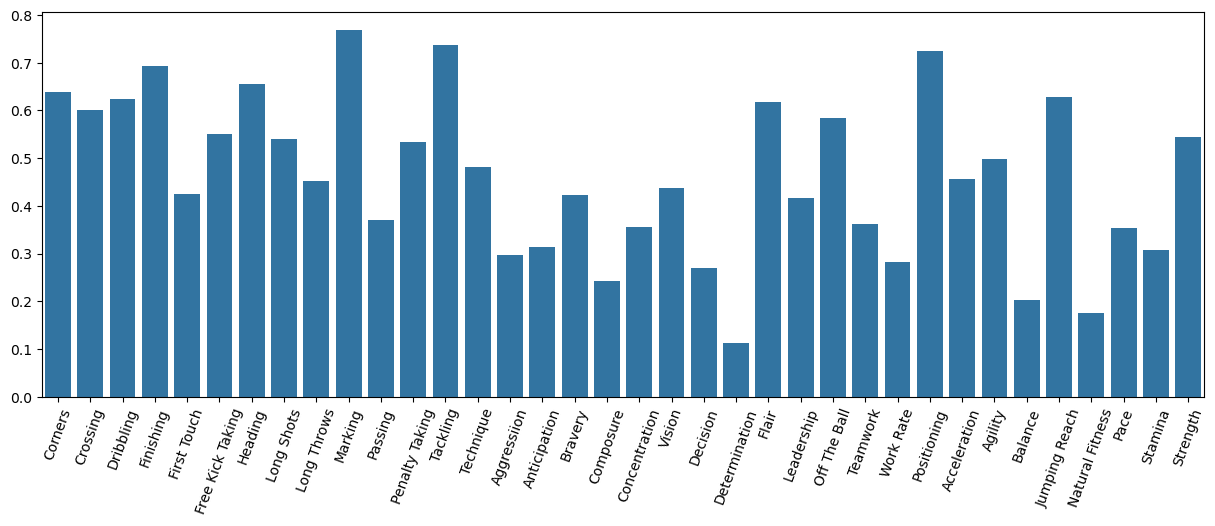

In [263]:
plt.subplots(figsize=(15,5))
plt.xticks(rotation=70)
sns.barplot(correlations)

In [264]:
col = 'Vision'
all_predictions.loc[test_indices, [col]].sort_values(col, ascending=False).head(10)

,Vision
_Player_,
Aleix García,16.591386
Cristiano Biraghi,15.290212
Lionel Messi,15.218890
Branco van den Boomen,15.191522
Luis Alberto,15.021409
Luis Alberto,15.021409
Luis Alberto,15.021409
Luis Alberto,15.021409
Monchu,14.992969


In [241]:
all_predictions[(all_predictions['Finishing']>=14) &
                (all_predictions['Composure']>=14) &
                (all_predictions['First Touch']>=14) &
                (all_predictions['Acceleration']>=14) &
                (all_predictions['Technique']>=14) &
                (all_predictions['Off The Ball']>=14)]

,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,...,Work Rate,Positioning,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength
_Player_,,,,,,,,,,,,,,,,,,,,,
Habib Diallo,6.855201,10.07998,12.87774,15.874702,14.278291,9.611037,15.788595,11.483508,6.02301,6.164572,...,15.021737,7.493281,14.647015,13.539138,14.999406,15.158636,15.201282,15.86222,15.006897,16.556918


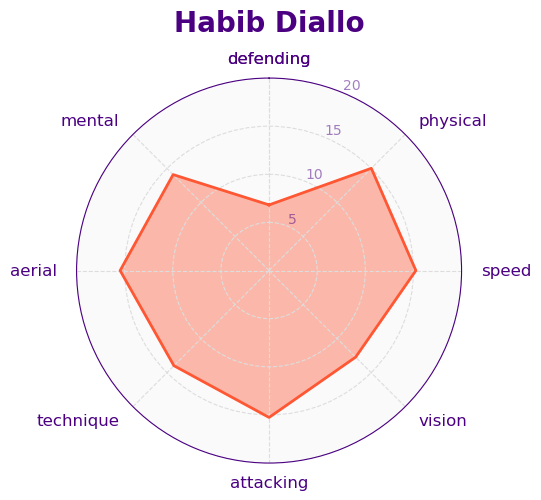

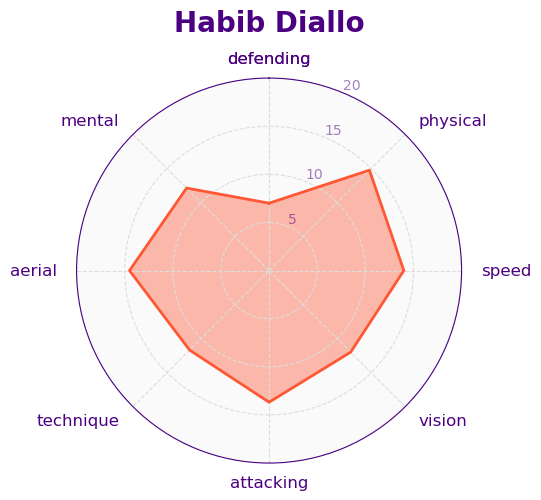

In [242]:
test_name = 'Habib Diallo'

model = mlp

predictions_2022 = model.predict(playground_X_2022.loc[[test_name]].values)
predictions_2022 = pd.Series(predictions_2022[0], index=FM_columns)
predictions_2022['_Player_'] = test_name
predictions_2022_graph = calculate_skill_nodes(predictions_2022)
plot_fm_radar(predictions_2022_graph, gk=False)

# predictions_2023 = model.predict(playground_X_2023.loc[[test_name]].values)
# predictions_2023 = pd.Series(predictions_2023[0], index=FM_columns[2:])
# predictions_2023['Name'] = test_name
# predictions_2023_graph = calculate_skill_nodes(predictions_2023)
# plot_fm_radar(predictions_2023_graph, gk=False)

real = playground_y.loc[[test_name]].values
real = pd.Series(real[0], index=FM_columns)
real['_Player_'] = test_name
real_graph = calculate_skill_nodes(real)
plot_fm_radar(real_graph, gk=False)

In [205]:
df1 = playground_X_2022
df2 = all_predictions

correlations = pd.DataFrame(index=df1.columns, columns=df2.columns)

for col1 in df1.columns:
    for col2 in df2.columns:
        correlations.loc[col1, col2] = np.corrcoef(df1[col1], df2[col2])[0, 1]

<Axes: >

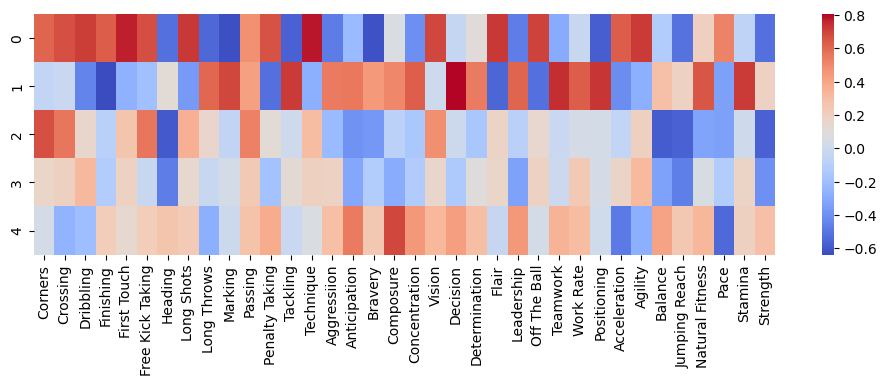

In [209]:
plt.subplots(figsize=(10,3))
plt.tight_layout()
sns.heatmap(correlations.dropna(axis=1).astype('float'), cmap='coolwarm')